Setup simulation

In [1]:
%matplotlib inline
# Imports
from rcfdtd_sim import Sim, Current, Mat, vis
import numpy as np
from scipy.fftpack import fft, fftfreq, fftshift
from matplotlib import pyplot as plt
from pathlib import Path
# Determine file save name
fsave = 'chcl3_sim.npz'
# Constants
c0 = 3e8 # um/ps
di = 0.03e-6 # 0.03 um
dn = di/c0 # (0.03 um) / (3e8 m/s) = 0.1 fs
epsilon0 = 8.854187e-12
mu0 = np.divide(1, np.multiply(epsilon0, np.square(c0)))
# Define bounds
i0 = -1e-6 # -1 um
i1 = 2e-6 # 2 um
n0 = -0.5e-12 # -0.5 ps
n1 = 2.5e-12 # 2.5 ps
# Calculate dimensions
nlen, ilen = Sim.calc_dims(n0, n1, dn, i0, i1, di)
# Create a arrays that hold the value of the center of each cell
t = np.linspace(n0+dn/2, n1+dn/2, nlen, endpoint=False)
z = np.linspace(i0+di/2, i1+di/2, ilen, endpoint=False)
# Notify user
print('nlen=%i, ilen=%i' % (nlen, ilen))

nlen=30000, ilen=102


Setup current

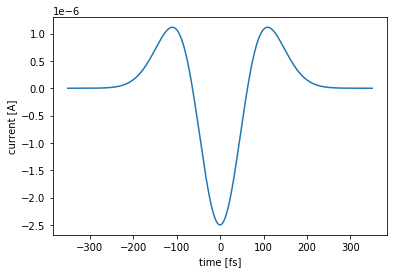

In [2]:
cp_loc_val = -0.5e-6 # -0.5 um
cp_time_val = 0 # 0 fs
# Find indicies
cp_loc_ind = np.argmin(np.abs(np.subtract(z, cp_loc_val)))
cp_time_ind = np.argmin(np.abs(np.subtract(t, cp_time_val)))
# Find start and end indicies in time
spread = 3500
cp_time_s = cp_time_ind - spread
cp_time_e = cp_time_ind + spread
# Make pulse
cpulse = np.append(np.diff(np.diff(np.exp(-((t[cp_time_s:cp_time_e]-cp_time_val)**2)/(8e-27)))), [0,0])
# Plot
plt.plot(t[cp_time_s:cp_time_e]*1e15, cpulse)
plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('time [fs]')
plt.ylabel('current [A]')
plt.show()
# Create Current object
current = Current(nlen, ilen, cp_time_s, cp_loc_ind, cpulse)

Setup material

In [3]:
# Set material length
m_len = 0.050e-6 # 50 nm
# Set locations
m_s_val = 0
m_e_val = m_s_val + m_len
# Calculate starting and ending indicies
m_s_ind = np.argmin(np.abs(np.subtract(z, m_s_val)))
m_e_ind = np.argmin(np.abs(np.subtract(z, m_e_val)))
# Determine matrix length
mlen = m_e_ind - m_s_ind

# Set A oscillator constants
a_a1 = np.complex64(2e16)
a_gamma = np.complex64(3e12)
a_freq = np.complex64(4.1e12)
# Calculate beta
a_ang_gamma = np.complex64(a_gamma * 2 * np.pi)
a_omega = np.complex64(a_freq * 2 * np.pi)
a_beta = np.sqrt(np.add(np.square(a_ang_gamma), -np.square(a_omega)), dtype=np.complex64)
a_a2 = -a_a1

# Create matrices
a_m = np.ones((1, mlen), dtype=np.complex64)
a_mgamma = a_m * a_ang_gamma
a_mbeta = a_m * a_beta
a_ma1 = a_m * a_a1
a_ma2 = a_m * a_a2

# Set B oscillator constants
b_a1 = np.complex64(2e16)
b_gamma = np.complex64(2e12)
b_freq = np.complex64(0.6e12)
# Calculate beta
b_ang_gamma = np.complex64(b_gamma * 2 * np.pi)
b_omega = np.complex64(b_freq * 2 * np.pi)
b_beta = np.sqrt(np.add(np.square(b_ang_gamma), -np.square(b_omega)), dtype=np.complex64)
b_a2 = -b_a1
# Create matrices
b_m = np.ones((1, mlen), dtype=np.complex64)
b_mgamma = b_m * b_ang_gamma
b_mbeta = b_m * b_beta
b_ma1 = b_m * b_a1
b_ma2 = b_m * b_a2

# Combine oscillators
ma1 = np.vstack((a_ma1, b_ma1))
ma2 = np.vstack((a_ma2, b_ma2))
mgamma = np.vstack((a_mgamma, b_mgamma))
mbeta = np.vstack((a_mbeta, b_mbeta))

# Define infinity permittivity
inf_perm = np.complex64(2.13e0)
# Create material
material = Mat(dn, ilen, nlen, m_s_ind, inf_perm, ma1, ma2, mgamma, mbeta, storelocs=[1])

Run the simulation

In [4]:
# Create Sim object
tqdmarg = {'desc': 'Executing simulation', 'leave': False}
s = Sim(i0, i1, di, n0, n1, dn, epsilon0, mu0, 'absorbing', current, material, nstore=int(nlen/50), storelocs=[5,ilen-6])
# Run simulation if simulation save doesn't exist
sim_file = Path(fsave)
if sim_file.is_file():
    # Load results
    dat = np.load(fsave)
    n = dat['n']
    ls = dat['ls']
    els = dat['els']
    erls = dat['erls']
    hls = dat['hls']
    hrls = dat['hrls']
    chi = dat['chi']
else:
    # Run simulation
    s.simulate(tqdmarg)
    # Export visualization
    #vis.timeseries(s, iunit='um', fname=fsave+'.mp4')
    # Export and save arrays
    n, ls, els, erls, hls, hrls = s.export_locs()
    ls_mat, chi = material.export_locs()
    #np.savez(fsave, n=n, ls=ls, els=els, erls=erls, hls=hls, hrls=hrls, chi=chi)

Plot results

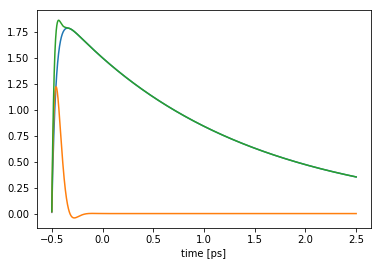

In [5]:
plt.plot(n*1e12, np.real(chi))
plt.plot(n*1e12, np.imag(chi))
plt.plot(n*1e12, np.abs(chi))
plt.xlabel('time [ps]')
plt.show()

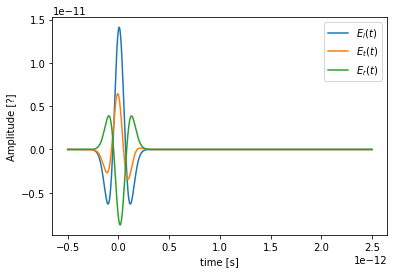

In [6]:
# Extract incident, transmitted, and reflected fields
inc = erls[:,1]
trans = els[:,1]
refl = els[:,0] - erls[:,0]

# Plot
plt.plot(n, np.real(inc), label='$E_i(t)$')
plt.plot(n, np.real(trans), label='$E_t(t)$')
plt.plot(n, np.real(refl), label='$E_r(t)$')
plt.ylabel('Amplitude [?]')
plt.xlabel('time [s]')
plt.legend()
plt.show()

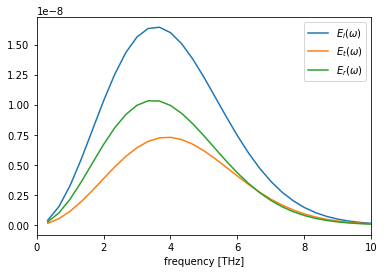

In [7]:
# Calculate time difference
dn = np.diff(n)[0] # Calculate time step difference in fs

# Calculate Fourier transforms
freq = fftfreq(nlen, dn) # in THz (since [dn]=[fs], 1/[dn] = 1/[fs] = 10^15/[s] = 10^3*10^12/[s] = 10^4*[THz])
incf = fft(inc)
transf = fft(trans)
reflf = fft(refl)

# Removeunwanted frequencies
freq = freq[1:int(nlen/2)]
incf = incf[1:int(nlen/2)]
transf = transf[1:int(nlen/2)]
reflf = reflf[1:int(nlen/2)]

# Plot transformed fields
plt.plot(freq * 1e-12, np.abs(incf), label='$E_i(\omega)$')
plt.plot(freq * 1e-12, np.abs(transf), label='$E_t(\omega)$')
plt.plot(freq * 1e-12, np.abs(reflf), label='$E_r(\omega)$')
plt.xlabel(r'frequency [THz]')
plt.xlim(0, 10)
plt.legend()
plt.show()

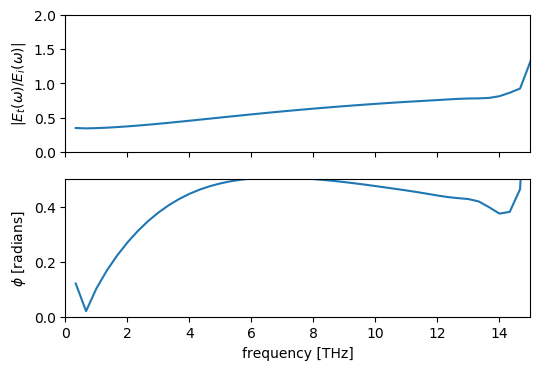

In [8]:
# Remove zero indicies from all arrays
nonzero_ind = np.nonzero(incf)
freq = freq[nonzero_ind]
incf = incf[nonzero_ind]
transf = transf[nonzero_ind]
reflf = reflf[nonzero_ind]

# Calculate spectrum in frequency
spec = np.divide(transf, incf)

# Remove zero indicies from all arrays
nonzero_ind = np.nonzero(spec)
freq = freq[nonzero_ind]
incf = incf[nonzero_ind]
transf = transf[nonzero_ind]
spec = spec[nonzero_ind]

# Extract phase and magnitude
spec_m = np.absolute(spec)
spec_a = np.abs(np.unwrap(np.angle(spec)))

# Plot
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, dpi=100)
ax0.plot(freq * 1e-12, spec_m)
ax1.plot(freq * 1e-12, spec_a)
ax1.set_xlim(0, 15)
ax0.set_ylim(0, 2)
ax1.set_ylim(0, 0.5)
ax0.set_ylabel(r'$\left|E_t(\omega)/E_i(\omega)\right|$')
ax1.set_ylabel(r'$\phi$ [radians]')
ax1.set_xlabel(r'frequency [THz]')
plt.show()

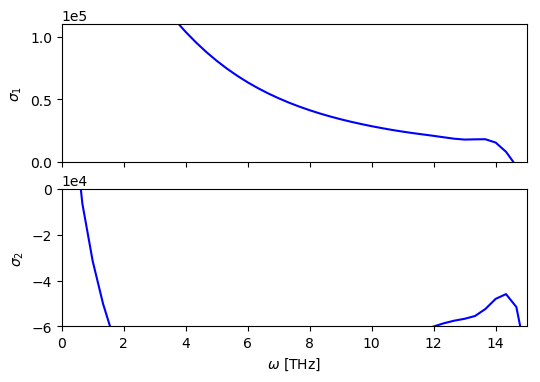

In [9]:
# Set constants
Z0 = np.multiply(mu0, c0) # Ohms (impedance of free space)

# Calculate the angular frequency
ang_freq = 2 * np.pi * freq # THz * 2pi

# Calculate conductivity
conductivity = np.multiply(np.divide(2, Z0*m_len), np.subtract(np.divide(1, spec), 1))

# Setup plot
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, dpi=100)
ax0.set_ylabel(r'$\sigma_1$')
ax1.set_ylabel(r'$\sigma_2$')
ax1.set_xlabel(r'$\omega$ [THz]')
ax1.set_xlim(0, 15)
ax0.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax0.set_ylim(0, 1.1e5)
ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax1.set_ylim(-6e4, 0)

# Plot conductivity
ax0.plot(freq * 1e-12, np.real(conductivity), 'b-')
ax1.plot(freq * 1e-12, np.imag(conductivity), 'b-')

Calculate index of refraction

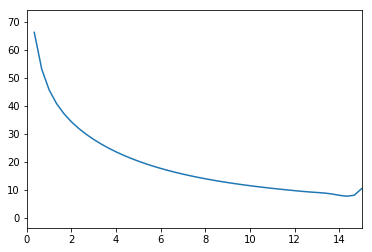

In [12]:
# Calculate index of refraction
n_complex = np.sqrt(inf_perm + np.divide(np.multiply(1j, conductivity), np.multiply(ang_freq, epsilon0)))

# Calculate the imaginary part of the index of refraction
n1 = np.real(n_complex)
kappa1 = np.imag(n_complex)

plt.plot(freq * 1e-12, n1)
plt.xlim(0, 15)
plt.show()